<a href="https://colab.research.google.com/github/AniB007/Time-Series-Stock-Prediction/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting Future Price of Nifty 50 Index**


### **About the Project**

The data here used is data of Nifty 50 index from 1st January 2014 to 13th Jan 2024 which compraises of

Date:- Trading days of Nifty 50.

Open:- Opening price of Nifty 50 on every trading session.

High:- Price of Nifty 50 which recorded highest price in that specific day.

Low:- Lowest price of Nifty 50 recorded on that specific day.

Price:- closing price at that particualar trading day.

Vol.:- No. of shares traded that specific day.

Change%:- Rate of change of price compared to previous day.

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#reading data from csv to pandas
nse = pd.read_csv("/content/drive/MyDrive/Nifty 50  Historical 10 years Data.csv")

# Cleaning & Processing the data as per requirement.

In [ ]:
nse

,Date,Price,Open,High,Low,Vol.,Change %
0,13-09-2024,"25,378.85","25,410.65","25,410.65","25,292.60",104.19M,-0.04%
1,12-09-2024,"25,388.90","25,059.65","25,433.35","24,941.45",380.07M,1.89%
2,11-09-2024,"24,918.45","25,034.00","25,113.70","24,885.15",279.23M,-0.49%
3,10-09-2024,"25,041.10","24,999.40","25,130.50","24,896.80",251.27M,0.42%
4,09-09-2024,"24,936.40","24,823.40","24,957.50","24,753.15",254.37M,0.34%
...,...,...,...,...,...,...,...
2643,07-01-2014,"6,162.25","6,203.90","6,221.50","6,144.75",138.56M,-0.47%
2644,06-01-2014,"6,191.45","6,220.85","6,224.70","6,170.25",118.35M,-0.32%
2645,03-01-2014,"6,211.15","6,194.55","6,221.70","6,171.25",139.04M,-0.16%
2646,02-01-2014,"6,221.15","6,301.25","6,358.30","6,211.30",158.13M,-1.28%


In [ ]:
# Checking for null values
nse.isna().sum()

,0
Date,0
Price,0
Open,0
High,0
Low,0
Vol.,4
Change %,0


In [ ]:
# Dropping Null Values
nse.dropna(inplace=True)

In [ ]:
nse.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2644 entries, 0 to 2647
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2644 non-null   object
 1   Price     2644 non-null   object
 2   Open      2644 non-null   object
 3   High      2644 non-null   object
 4   Low       2644 non-null   object
 5   Vol.      2644 non-null   object
 6   Change %  2644 non-null   object
dtypes: object(7)
memory usage: 165.2+ KB


In [ ]:
#Converting Data Types
nse["Date"] = pd.to_datetime(nse["Date"])
nse['Price'] = nse['Price'].astype(str).str.replace(",", "", regex=False).astype(float)
nse['Open'] = nse['Open'].astype(str).str.replace(",", "", regex=False).astype(float)
nse['High'] = nse['High'].astype(str).str.replace(",", "", regex=False).astype(float)
nse['Low'] = nse['Low'].astype(str).str.replace(",", "", regex=False).astype(float)
nse['Volume'] = (nse['Vol.'].astype(str).str.replace("M", "", regex=False).astype(str).str.replace("B","",regex= False).astype(float))*1e6
# Converting B(Billions) to multiply with 1e9 & M(Millions) to multiply with 1e6
nse.loc[nse['Vol.'].str.contains('B'), 'Volume'] *= 1e9
nse.loc[nse['Vol.'].str.contains('M'), 'Volume'] *= 1e6
nse['Change %'] = (nse['Change %'].astype(str).str.replace("%", "", regex=False).astype(float))/100

In [ ]:
# Removing Vol. columns
nse.drop(['Vol.'], axis=1, inplace=True)
nse = nse.set_index("Date")   # Setting Date as Index

In [ ]:
# Converting daily data to monthly data for quick computation
monthly= nse.resample('M').mean()
monthly

,Price,Open,High,Low,Change %,Volume
Date,,,,,,
2014-01-31,6223.163043,6230.163043,6257.306522,6196.034783,-0.001470,1.456774e+14
2014-02-28,6098.744737,6091.157895,6120.005263,6063.250000,0.001626,1.471937e+14
2014-03-31,6507.980952,6490.626190,6533.242857,6468.230952,0.003162,1.839490e+14
2014-04-30,6754.736111,6764.319444,6791.261111,6723.380556,-0.000050,1.484744e+14
2014-05-31,7083.157143,7082.226190,7143.019048,7029.469048,0.003710,2.039433e+14
...,...,...,...,...,...,...
2024-05-31,22485.231818,22498.484091,22594.981818,22373.636364,-0.000127,3.050277e+14
2024-06-30,23364.044737,23381.965789,23506.918421,23163.807895,0.003521,4.081579e+14
2024-07-31,24495.152273,24472.997727,24574.175000,24357.427273,0.001773,3.223623e+14


# Checking the Trend, Seasonality & Residuals of Time Series Data

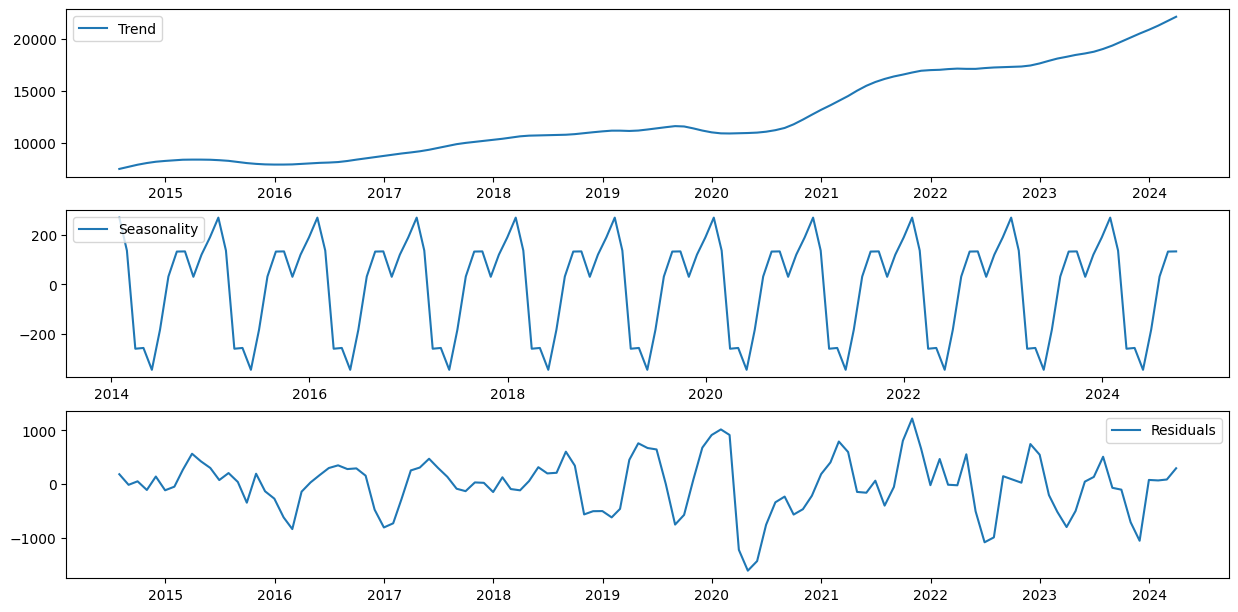

In [ ]:
# Breaking data into Trend, Seasonality & Residuals
resluts = seasonal_decompose(monthly["Price"], model='additive', period=12)

plt.figure(figsize=(15, 10))
plt.subplot(412)
plt.plot(resluts.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(resluts.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(resluts.resid, label='Residuals')
plt.legend(loc='best')
plt.show()


# Prepering This Time Series Data For Modelling.

In [ ]:
# Splitting data into 80:20 ratio
train_size = int(len(monthly) * 0.8)
train_data = monthly[:train_size]
test_data = monthly[train_size:]
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (103, 6)
Test data shape: (26, 6)


In [ ]:
train_exog = train_data[['Open', 'High', 'Low']]
train_endog = train_data['Price']
test_exog = test_data[['Open', 'High', 'Low']]
test_endog = test_data['Price']

In [ ]:
# Forecating with Sarima model as our data has seasonality
model = SARIMAX(train_endog,exog=train_exog,order=(9,2,9),seasonal_order=(3,0,1,12))
result= model.fit()

In [ ]:
#Prediting values
sarima_forecast = result.forecast(steps=len(test_endog),exog=test_exog)
# Finding out Mean squared error
mse= mean_squared_error(test_endog, sarima_forecast)
print("Mean Squared Error:", mse)

Mean Squared Error: 212.60709767706174


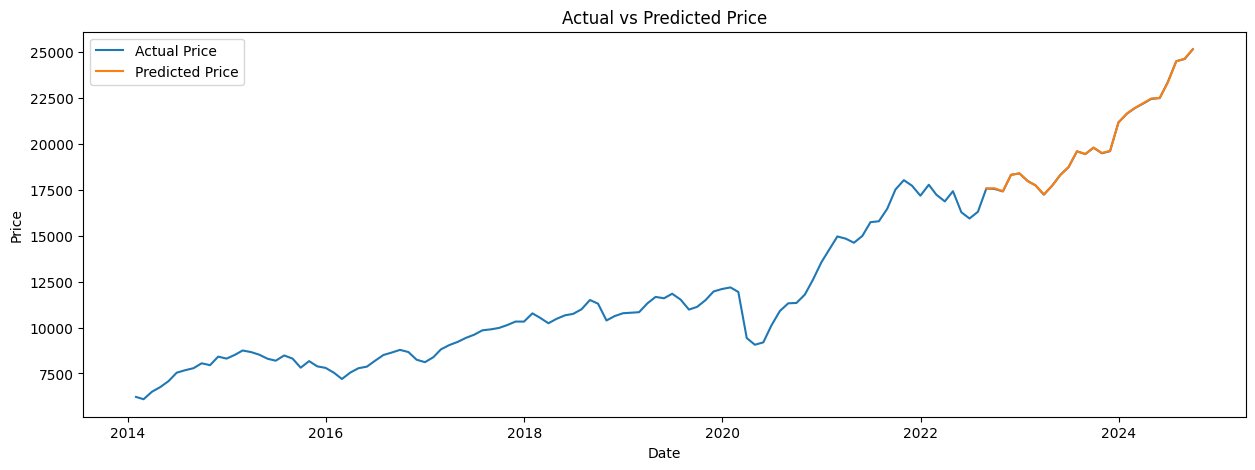

In [ ]:
# Visualizing data with predicted and actual values
plt.figure(figsize=(15,5))
plt.plot(monthly.index, monthly["Price"], label='Actual Price')
plt.plot(sarima_forecast.index, sarima_forecast, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Price')
plt.legend()

# **Conclusion:-**

* This project mainly deals with time series data which is different
from regular data so we can use Train_Test split as it shuffles all the data everytime. So we have to use Time Series Split CV or manually divide data into required ratio. Here 80:20 split is being used.
* The data is converted from daily to monthly data for quick compution.
* The SARIMAX model is used for projection of data as it takes seasons into account.
* The model was evaluated using the Mean Squared Error (MSE), which was found to be 212. This value suggests average fit with limited data we have. However, it is important to acknowledge that using monthly data might have resulted in the loss of some daily trends or patterns.
* In Seasonal Decompose period 12 is used as it is monthy data.
* The PRICE is taken as Endogeneous variable and rest OPEN,HIGH,LOW is taken as Exegenous variable or Independent variable.
* Sarima Parameters p(past),d(diferencing),q(average) & P,D,Q,s(Seasonal Length) takes seasonal pattern into account with same as precious parameters.
* Overall, this project demonstrates the application of time series analysis for forecasting financial markets. Accurate predictions of the NIFTY 50 index have significant value for investors and financial analysts.